In [1]:
import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from lmfit import Model
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from scipy.stats import norm
from functools import reduce
from scipy.stats import zscore
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import unary_union
from IPython.display import display
from scipy.optimize import curve_fit
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm

In [2]:
# Define column names based on the header in the SRL file
column_names = [
    "Source_id", "Isl_id", "RA", "E_RA", "DEC", "E_DEC", "Total_flux", "E_Total_flux",
    "Peak_flux", "E_Peak_flux", "RA_max", "E_RA_max", "DEC_max", "E_DEC_max", "Maj", 
    "E_Maj", "Min", "E_Min", "PA", "E_PA", "Maj_img_plane", "E_Maj_img_plane", 
    "Min_img_plane", "E_Min_img_plane", "PA_img_plane", "E_PA_img_plane", "DC_Maj", 
    "E_DC_Maj", "DC_Min", "E_DC_Min", "DC_PA", "E_DC_PA", "DC_Maj_img_plane", 
    "E_DC_Maj_img_plane", "DC_Min_img_plane", "E_DC_Min_img_plane", "DC_PA_img_plane", 
    "E_DC_PA_img_plane", "Isl_Total_flux", "E_Isl_Total_flux", "Isl_rms", "Isl_mean", 
    "Resid_Isl_rms", "Resid_Isl_mean", "S_Code"
]

In [3]:
spw = [
       2,
       3 , 
       4, 
       5, 
       6, 
       8, 
       15, 
       16, 
       17
       ]

In [4]:
"""
Read PyBDSF .srl files for multiple SPWs and datasets,
and build one combined DataFrame per SPW.

- Datasets: 23, 25, 32, 36
- Each SPW has up to 4 SRL files (one per dataset)
"""

import pandas as pd

# ======================================
# CONFIGURATION
# ======================================

# Datasets you have
DATASETS = ["23", "25", "32", "36"]

# Path template for SRL files
# Example produced path:
#   ../paper1/spw/23_pb/spw15-2.5arcsec-nit5000-awproject.pbcor.pybdsf.srl
SRL_TEMPLATE = (
    "../paper1/spw/{ds}_pb/"
    "spw{spw}-2.5arcsec-nit5000-awproject.pbcor.pybdsf.srl"
)



# ======================================
# SMALL HELPER FUNCTIONS
# ======================================

def build_paths_for_spw(spw_value):
    """
    Return a list of SRL file paths for one SPW across all datasets.
    """
    paths = []
    for ds in DATASETS:
        path = SRL_TEMPLATE.format(ds=ds, spw=spw_value)
        paths.append(path)
    return paths


def read_srl_file(path):
    """
    Read a single SRL file.
    Returns a DataFrame or None if file is missing.
    Uses sep='\\s+' to avoid FutureWarning from delim_whitespace.
    """
    try:
        df = pd.read_csv(
            path,
            sep=r"\s+",           # <-- replaces delim_whitespace=True
            comment="#",
            names=column_names,
            engine="python"       # safer for regex separators
        )
        return df
    except FileNotFoundError:
        print(f"File not found: {path}")
        return None


# ======================================
# EXECUTION: LOOP OVER SPWs
# ======================================

# This script assumes you already defined `spw` and `column_names`
# before running it.

srl_file_paths = []   # list of lists: one list of paths per SPW
dataframes     = []   # one combined DataFrame per SPW

for s in spw:
    # ---- 1) Build paths for this SPW ----
    paths = build_paths_for_spw(s)
    srl_file_paths.append(paths)

    # ---- 2) Read all existing SRL files for this SPW ----
    spw_data = []
    for path in paths:
        df = read_srl_file(path)
        if df is not None:
            spw_data.append(df)

    # ---- 3) Concatenate into a single DataFrame for this SPW ----
    if spw_data:
        combined_df = pd.concat(spw_data, ignore_index=True)
        dataframes.append(combined_df)

print(f"Total dataframes read: {len(dataframes)}")


Total dataframes read: 9


In [5]:
combined_df.shape

(931, 45)

In [6]:
len(dataframes[8])

931

/var/folders/l1/vk05brrd5vgg5rxsglsqwbjh0000gn/T/ipykernel_28035/2700055740.py:55: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


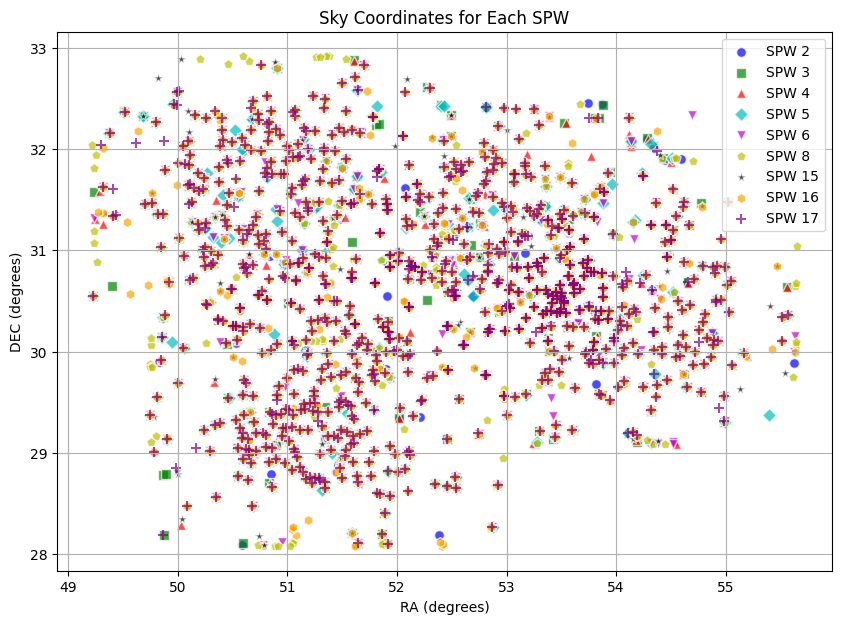

In [7]:
"""
Plot RA–DEC positions of sources for each SPW using different
markers and colors.
"""

import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

# ======================================
# CONFIGURATION
# ======================================

# Markers and colors per SPW
MARKERS = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', '+']
COLORS  = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple']

FIGSIZE = (10, 7)
POINT_SIZE = 50
ALPHA = 0.7


# ======================================
# BASIC CHECKS
# ======================================

n_spw = len(dataframes)

if n_spw > len(MARKERS) or n_spw > len(COLORS):
    raise ValueError(
        "Not enough markers or colors for the number of SPWs."
    )


# ======================================
# PLOTTING
# ======================================

plt.figure(figsize=FIGSIZE)

for i in range(n_spw):

    df     = dataframes[i]
    marker = MARKERS[i]
    color  = COLORS[i]

    # ---- Convert RA/DEC to SkyCoord ----
    coords = SkyCoord(
        ra=df['RA'].values * u.degree,
        dec=df['DEC'].values * u.degree,
        frame='icrs'
    )

    # ---- Scatter plot ----
    plt.scatter(
        coords.ra.deg,
        coords.dec.deg,
        label=f"SPW {spw[i]}",
        s=POINT_SIZE,
        alpha=ALPHA,
        marker=marker,
        color=color,
        edgecolors='w'
    )

# ======================================
# AXES & DECORATION
# ======================================

plt.xlabel("RA (degrees)")
plt.ylabel("DEC (degrees)")
plt.title("Sky Coordinates for Each SPW")

plt.legend()
plt.grid(True)

plt.show()


# Find duplicates

In [8]:
"""
Functions to find and handle duplicated sources in a catalog
based on positional matching.
"""

import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u


def find_potential_duplicates(df, ra1, dec1, tolerance_arcsec=9):
    """
    Find potential duplicates for a given source using angular separation.

    Parameters
    ----------
    df : pandas.DataFrame
        Catalog containing at least 'RA' and 'DEC' columns (degrees).
    ra1, dec1 : float
        Coordinates of the source to match (degrees).
    tolerance_arcsec : float
        Maximum angular separation to consider as duplicate (arcsec).

    Returns
    -------
    match_indices : numpy.ndarray
        Indices of all catalog entries within the given tolerance.
    """
    source_coord = SkyCoord(ra=ra1 * u.deg, dec=dec1 * u.deg, frame="icrs")
    catalog_coords = SkyCoord(
        ra=df["RA"].values * u.deg,
        dec=df["DEC"].values * u.deg,
        frame="icrs"
    )

    separations = source_coord.separation(catalog_coords).arcsecond
    match_indices = np.where(separations <= tolerance_arcsec)[0]

    return match_indices


def process_dataframe(df, spw_value, tolerance_arcsec=9):
    """
    Process a single DataFrame to find and handle repeated sources.

    For each group of sources within `tolerance_arcsec`, keep the one with the
    smallest E_Total_flux and mark the rest as "repeated" for bookkeeping.

    Parameters
    ----------
    df : pandas.DataFrame
        Input catalog for a single SPW.
    spw_value : int or float
        The SPW identifier (stored in repeated sources).
    tolerance_arcsec : float
        Matching radius used to find duplicates.

    Returns
    -------
    non_duplicated_df : pandas.DataFrame
        Catalog where each group of close matches is reduced to one source.
    current_repeated_sources : list of pandas.Series
        List of rows corresponding to discarded duplicates.
    """
    non_duplicated_sources = []
    processed = np.zeros(len(df), dtype=bool)
    current_repeated_sources = []

    for index, row in df.iterrows():
        if processed[index]:
            continue

        ra1, dec1 = row["RA"], row["DEC"]

        match_indices = find_potential_duplicates(
            df,
            ra1,
            dec1,
            tolerance_arcsec=tolerance_arcsec
        )

        if len(match_indices) > 0:
            processed[match_indices] = True

            # Among matches, keep the one with minimum E_Total_flux
            best_source_idx = df.loc[match_indices, "E_Total_flux"].idxmin()
            main_source = df.loc[best_source_idx].copy()

            # All other matches are "repeated"
            for duplicate_idx in match_indices:
                if duplicate_idx != best_source_idx:
                    duplicate_row = df.loc[duplicate_idx].copy()
                    duplicate_row["SPW"] = spw_value
                    current_repeated_sources.append(duplicate_row)

            non_duplicated_sources.append(main_source)
        else:
            non_duplicated_sources.append(row)
            processed[index] = True

    non_duplicated_df = pd.DataFrame(non_duplicated_sources)
    return non_duplicated_df, current_repeated_sources


In [9]:
"""
Functions for scaling flux columns and saving catalogs to CSV.
"""

import pandas as pd

FLUX_COLUMNS_MJY = [
    "Total_flux",
    "E_Total_flux",
    "Peak_flux",
    "E_Peak_flux",
    "S_code",
]


def adjust_and_save_df(df, spw_value, file_path_prefix):
    """
    Convert selected flux columns to mJy (×1e3) and save the result to CSV.

    Parameters
    ----------
    df : pandas.DataFrame
        Non-duplicated catalog.
    spw_value : int or float
        SPW identifier, used in the output file name.
    file_path_prefix : str
        Directory where CSV file will be written.

    Returns
    -------
    output_path : str
        Full path of the saved CSV file.
    """
    # Scale flux-related columns if present
    for col in FLUX_COLUMNS_MJY:
        if col in df.columns:
            df[col] = df[col] * 1e3

    output_path = f"{file_path_prefix}/spw{spw_value}.csv"
    try:
        df.to_csv(output_path, index=False)
        print(f"Successfully saved: {output_path}")
    except Exception as e:
        print(f"Error saving file {output_path}: {e}")

    return output_path


In [10]:
"""
Plotting functions for RA/DEC distributions of sources.
"""

import matplotlib.pyplot as plt
import pandas as pd  # useful for type hints / operations

DEFAULT_FIGSIZE = (10, 7)


def plot_sources(all_sources, highlighted_sources, figsize=DEFAULT_FIGSIZE):
    """
    Plot all source positions and highlight repeated sources.

    Parameters
    ----------
    all_sources : pandas.DataFrame
        Combined catalog of all non-duplicated sources.
    highlighted_sources : pandas.DataFrame
        Catalog of repeated sources (may be empty).
    figsize : tuple
        Figure size for the plot.
    """
    plt.figure(figsize=figsize)

    # All sources (background)
    plt.scatter(
        all_sources["RA"],
        all_sources["DEC"],
        c="blue",
        label="All Sources",
        alpha=0.6
    )

    # Highlight repeated sources (if present)
    if not highlighted_sources.empty:
        plt.scatter(
            highlighted_sources["RA"],
            highlighted_sources["DEC"],
            c="red",
            label="Repeated Sources",
            alpha=0.8
        )

    plt.xlabel("RA (degrees)")
    plt.ylabel("DEC (degrees)")
    plt.title("Source Locations with Repeated Sources Highlighted")
    plt.legend()
    plt.grid(True)
    plt.show()


SPW 2: before (895, 45), after (789, 45)
Successfully saved: ../paper1/csv/spw2.csv
Saved processed DataFrame for SPW 2 to ../paper1/csv/spw2.csv
SPW 3: before (907, 45), after (801, 45)
Successfully saved: ../paper1/csv/spw3.csv
Saved processed DataFrame for SPW 3 to ../paper1/csv/spw3.csv
SPW 4: before (914, 45), after (807, 45)
Successfully saved: ../paper1/csv/spw4.csv
Saved processed DataFrame for SPW 4 to ../paper1/csv/spw4.csv
SPW 5: before (903, 45), after (801, 45)
Successfully saved: ../paper1/csv/spw5.csv
Saved processed DataFrame for SPW 5 to ../paper1/csv/spw5.csv
SPW 6: before (842, 45), after (757, 45)
Successfully saved: ../paper1/csv/spw6.csv
Saved processed DataFrame for SPW 6 to ../paper1/csv/spw6.csv
SPW 8: before (820, 45), after (743, 45)
Successfully saved: ../paper1/csv/spw8.csv
Saved processed DataFrame for SPW 8 to ../paper1/csv/spw8.csv
SPW 15: before (947, 45), after (832, 45)
Successfully saved: ../paper1/csv/spw15.csv
Saved processed DataFrame for SPW 15 t

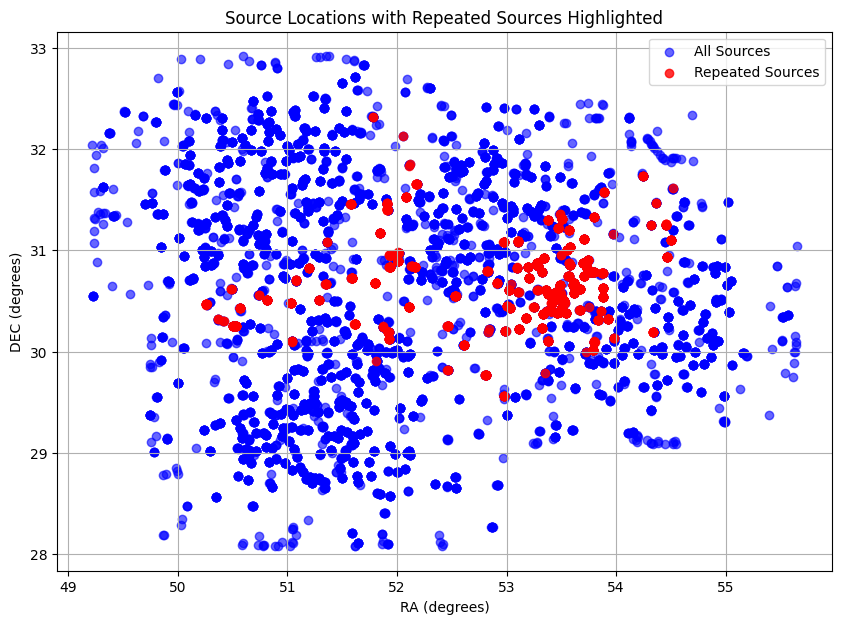

In [11]:
# ======================================
# PARAMETERS
# ======================================

file_path_prefix = "../paper1/csv"
tolerance_arcsec = 14 # matching tolerance in arcseconds


# ======================================
# DEDUPLICATE EACH SPW + SAVE
# ======================================

non_duplicated_dataframes = []   # cleaned catalogs, one per SPW
repeated_sources_list    = []   # flat list of repeated source rows

for i, df in enumerate(dataframes):
    spw_value = spw[i]

    # --- deduplicate one SPW ---
    non_duplicated_df, current_repeated_sources = process_dataframe(
        df,
        spw_value,
        tolerance_arcsec=tolerance_arcsec,
    )

    print(
        f"SPW {spw_value}: "
        f"before {df.shape}, after {non_duplicated_df.shape}"
    )

    # --- save cleaned catalog for this SPW ---
    output_path = adjust_and_save_df(
        non_duplicated_df,
        spw_value,
        file_path_prefix,
    )
    print(f"Saved processed DataFrame for SPW {spw_value} to {output_path}")

    non_duplicated_dataframes.append(non_duplicated_df)

    # store repeated sources, if any
    if current_repeated_sources:
        repeated_sources_list.extend(current_repeated_sources)


# ======================================
# BUILD COMBINED TABLES
# ======================================

# all non-duplicated sources from all SPWs
all_sources = pd.concat(non_duplicated_dataframes, ignore_index=True)

# all repeated sources (may be empty)
if repeated_sources_list:
    highlighted_sources = pd.DataFrame(repeated_sources_list)
else:
    highlighted_sources = pd.DataFrame()   # empty, avoids errors later


# ======================================
# PLOT
# ======================================

plot_sources(all_sources, highlighted_sources)


# Making big table

In [12]:
# ======================================
# PARAMETERS
# ======================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u

# Order of SPWs in the final wide table
SPW_ORDER = [15, 16, 17, 2, 3, 4, 5, 6, 8]

# Path template for per-SPW catalogs
# Change here if your filenames differ
SPW_CSV_TEMPLATE = "../paper1/csv/spw{spw}.csv"

# Positional matching tolerance (for grouping detections into unique sources)
TOLERANCE_ARCSEC = 14
TOLERANCE_DEG = TOLERANCE_ARCSEC / 3600.0

# Regions to remove (the “circled blobs”)
# Each region: (RA_min, RA_max, DEC_min, DEC_max)
BAD_REGIONS = [
    (54.3, 54.5, 31.9, 32.1),  # top blob
    (54.1, 54.6, 29.0, 29.2),  # bottom blob
]

# (Optional, for later spectral index work)
FREQUENCIES_MHZ = {
    1: 1345.5883,
    2: 1409.5883,
    3: 1473.5883,
    4: 1653.5753,
    5: 1717.5753,
    6: 1781.57534,
    7: 1845.5753,
    8: 1909.5753,
    9: 2037.5753,
}


In [13]:
# ======================================
# LOAD PER-SPW CATALOGS AND STACK
# ======================================

def load_spw_catalogs(spw_list, csv_template):
    """
    Load one CSV per SPW and stack into a single long DataFrame.
    Adds a 'SPW' column.
    """
    all_rows = []

    for spw in spw_list:
        path = csv_template.format(spw=spw)
        df = pd.read_csv(path)

        if "RA" not in df.columns or "DEC" not in df.columns:
            raise KeyError(f"RA/DEC missing in {path}")

        df["SPW"] = spw
        all_rows.append(df)

        print(f"Loaded SPW {spw} from {path}, shape={df.shape}")

    stacked = pd.concat(all_rows, ignore_index=True)
    return stacked

all_df = load_spw_catalogs(SPW_ORDER, SPW_CSV_TEMPLATE)
print("Combined shape (all SPWs stacked):", all_df.shape)


Loaded SPW 15 from ../paper1/csv/spw15.csv, shape=(832, 46)
Loaded SPW 16 from ../paper1/csv/spw16.csv, shape=(854, 46)
Loaded SPW 17 from ../paper1/csv/spw17.csv, shape=(808, 46)
Loaded SPW 2 from ../paper1/csv/spw2.csv, shape=(789, 46)
Loaded SPW 3 from ../paper1/csv/spw3.csv, shape=(801, 46)
Loaded SPW 4 from ../paper1/csv/spw4.csv, shape=(807, 46)
Loaded SPW 5 from ../paper1/csv/spw5.csv, shape=(801, 46)
Loaded SPW 6 from ../paper1/csv/spw6.csv, shape=(757, 46)
Loaded SPW 8 from ../paper1/csv/spw8.csv, shape=(743, 46)
Combined shape (all SPWs stacked): (7192, 46)


In [14]:
# ======================================
# FILTER BAD REGIONS + CLEAN RA/DEC
# ======================================

def remove_bad_regions(df, regions):
    """
    Remove sources falling inside any of the specified rectangular regions.
    Also return a DataFrame of the removed sources.

    regions: list of (RA_min, RA_max, DEC_min, DEC_max)
    """
    mask_delete = np.zeros(len(df), dtype=bool)

    for (ra_min, ra_max, dec_min, dec_max) in regions:
        region_mask = (
            (df["RA"] >= ra_min) & (df["RA"] <= ra_max) &
            (df["DEC"] >= dec_min) & (df["DEC"] <= dec_max)
        )
        mask_delete |= region_mask

    removed = df[mask_delete].copy()
    filtered = df[~mask_delete].reset_index(drop=True)
    n_delete = int(mask_delete.sum())

    return filtered, removed, n_delete


# Make sure RA/DEC are numeric
all_df["RA"] = pd.to_numeric(all_df["RA"], errors="coerce")
all_df["DEC"] = pd.to_numeric(all_df["DEC"], errors="coerce")

bad_coord_rows = all_df[all_df["RA"].isna() | all_df["DEC"].isna()]
print(f"Found {len(bad_coord_rows)} rows with non-numeric RA/DEC (will be dropped).")

all_df = all_df.dropna(subset=["RA", "DEC"]).reset_index(drop=True)

# Remove bad regions (now we KEEP the removed sources separately)
all_df, bad_blob_sources, n_removed = remove_bad_regions(all_df, BAD_REGIONS)
print(f"Filtered out {n_removed} sources in the circled areas.")
print("Cleaned combined shape:", all_df.shape)
print("Bad blob sources shape:", bad_blob_sources.shape)


Found 0 rows with non-numeric RA/DEC (will be dropped).
Filtered out 26 sources in the circled areas.
Cleaned combined shape: (7166, 46)
Bad blob sources shape: (26, 46)


In [15]:
# ======================================
# GROUP DETECTIONS INTO UNIQUE SOURCES
# ======================================

def assign_positional_groups(df, tolerance_deg):
    """
    Assign a TempGroupID so that all sources within tolerance_deg of each other
    belong to the same group.
    """
    coords = SkyCoord(
        ra=df["RA"].values * u.deg,
        dec=df["DEC"].values * u.deg
    )

    source_ids = -np.ones(len(df), dtype=int)
    current_id = 0

    for i in range(len(df)):
        if source_ids[i] != -1:
            continue

        separations = coords.separation(coords[i]).degree
        match_indices = np.where(
            (separations <= tolerance_deg) & (source_ids == -1)
        )[0]

        source_ids[match_indices] = current_id
        current_id += 1

    df = df.copy()
    df["TempGroupID"] = source_ids
    return df, current_id

all_df, n_groups = assign_positional_groups(all_df, TOLERANCE_DEG)
print(f"Assigned {n_groups} positional groups (TempGroupID).")


Assigned 1410 positional groups (TempGroupID).


In [16]:
# ======================================
# VPR IAU-STYLE SOURCE NAME
# ======================================

def make_vpr_name(ra_deg, dec_deg, prefix="VPR"):
    """
    Turn RA/DEC in degrees into a truncated VPR JHHMMSS.s+DDMMSS.s style name.
    """
    coord = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg)

    ra_str = coord.ra.to_string(
        unit=u.hourangle, sep="", precision=1, pad=True
    )  # HHMMSS.s
    dec_str = coord.dec.to_string(
        unit=u.deg, sep="", alwayssign=True, precision=1, pad=True
    )  # DDMMSS.s

    # Truncate to one decimal place manually (to mimic your previous style)
    ra_trunc = ra_str.split(".")[0] + "." + ra_str.split(".")[1][0]
    dec_trunc = dec_str.split(".")[0] + "." + dec_str.split(".")[1][0]

    return f"{prefix} J{ra_trunc}{dec_trunc}"


In [17]:
# ======================================
# BUILD WIDE TABLE: ONE ROW PER SOURCE
# ======================================

rows = []
grouped = all_df.groupby("TempGroupID")

for group_id, group in grouped:
    # 1. Choose best position using smallest combined RA/DEC error
    #    (fall back to first row if errors missing)
    if {"E_RA", "E_DEC"}.issubset(group.columns):
        err2 = group["E_RA"]**2 + group["E_DEC"]**2
        best_row = group.loc[err2.idxmin()]
    else:
        best_row = group.iloc[0]

    ra = best_row["RA"]
    dec = best_row["DEC"]
    source_name = make_vpr_name(ra, dec)

    row = {
        "Source_ID": source_name,
        "RA": ra,
        "DEC": dec,
    }

    if "E_RA" in group.columns:
        row["E_RA"] = best_row["E_RA"]
    else:
        row["E_RA"] = np.nan

    if "E_DEC" in group.columns:
        row["E_DEC"] = best_row["E_DEC"]
    else:
        row["E_DEC"] = np.nan

    # 2. Fill fluxes per SPW
    for spw in SPW_ORDER:
        match = group[group["SPW"] == spw]

        if not match.empty:
            d = match.iloc[0]

            row[f"Total_S_SPW{spw}"]    = d.get("Total_flux",    np.nan)
            row[f"E_Total_S_SPW{spw}"]  = d.get("E_Total_flux",  np.nan)
            row[f"Peak_S_SPW{spw}"]     = d.get("Peak_flux",     np.nan)
            row[f"E_Peak_S_SPW{spw}"]   = d.get("E_Peak_flux",   np.nan)
            row[f"RMS_SPW{spw}"]        = d.get("Isl_rms",       np.nan)
        else:
            row[f"Total_S_SPW{spw}"]    = np.nan
            row[f"E_Total_S_SPW{spw}"]  = np.nan
            row[f"Peak_S_SPW{spw}"]     = np.nan
            row[f"E_Peak_S_SPW{spw}"]   = np.nan
            row[f"RMS_SPW{spw}"]        = np.nan

    # 3. No alpha yet — leave out for now.
    #    Later we can add it once you have spectral index fits.

    rows.append(row)

final_df = pd.DataFrame(rows)
print("Final combined table shape:", final_df.shape)
final_df.head()


Final combined table shape: (1410, 50)


,Source_ID,RA,DEC,E_RA,E_DEC,Total_S_SPW15,E_Total_S_SPW15,Peak_S_SPW15,E_Peak_S_SPW15,RMS_SPW15,...,Total_S_SPW6,E_Total_S_SPW6,Peak_S_SPW6,E_Peak_S_SPW6,RMS_SPW6,Total_S_SPW8,E_Total_S_SPW8,Peak_S_SPW8,E_Peak_S_SPW8,RMS_SPW8
0,VPR J033003.7+303256.0,52.515260,30.548882,0.001575,0.001946,149.165569,28.711927,54.126571,7.926031,0.007423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VPR J033003.0+303533.6,52.512313,30.592675,0.000997,0.001673,40.976928,12.381816,39.330886,6.874174,0.006902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VPR J032959.1+303622.3,52.496272,30.606200,0.003267,0.001217,19.322873,10.674727,21.845983,6.385664,0.006902,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,VPR J032942.6+320502.7,52.427391,32.084071,0.000361,0.000325,223.447935,15.689522,183.916878,7.935406,0.007617,...,88.508572,26.051352,71.807086,12.950529,0.012536,NaN,NaN,NaN,NaN,NaN
4,VPR J032940.2+312455.1,52.417541,31.415318,0.000234,0.000212,316.326684,28.669908,270.640934,14.895986,0.014393,...,33.067358,10.870993,32.364759,6.121556,0.006165,NaN,NaN,NaN,NaN,NaN


In [18]:
# ======================================
# SAVE + QUICK CHECK PLOT
# ======================================

out_path = "../paper1/csv/combined_sources_all_spw.csv"
final_df.to_csv(out_path, index=False)
print(f"✅ Done. Saved to {out_path}")


✅ Done. Saved to ../paper1/csv/combined_sources_all_spw.csv


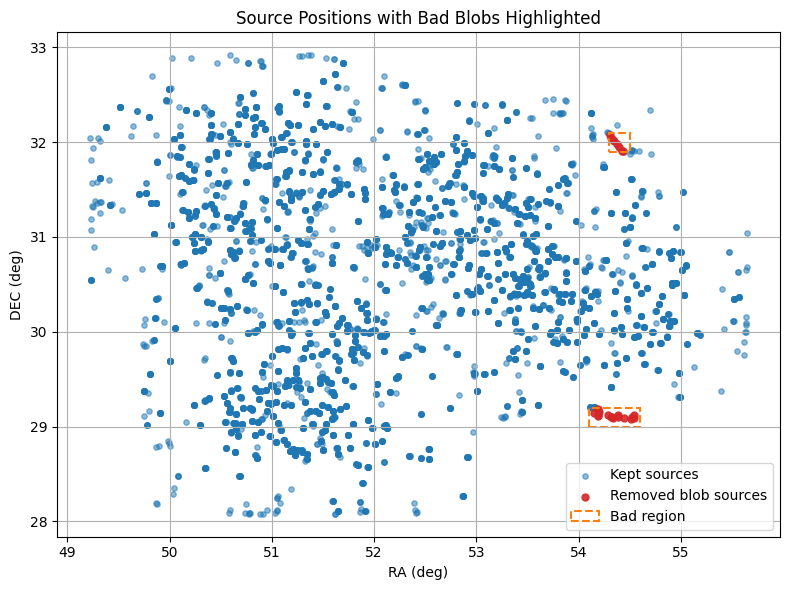

In [19]:
# ======================================
# PLOT GOOD SOURCES + BAD BLOBS
# ======================================

from matplotlib.patches import Rectangle


plt.figure(figsize=(8, 6))

# Good sources
plt.scatter(
    all_df["RA"], all_df["DEC"],
    s=15, alpha=0.5, label="Kept sources", color="tab:blue"
)

# Removed blob sources (if any)
if not bad_blob_sources.empty:
    plt.scatter(
        bad_blob_sources["RA"], bad_blob_sources["DEC"],
        s=25, alpha=0.9, label="Removed blob sources", color="tab:red"
    )

# Draw rectangles for BAD_REGIONS
ax = plt.gca()
for (ra_min, ra_max, dec_min, dec_max) in BAD_REGIONS:
    width  = ra_max - ra_min
    height = dec_max - dec_min
    rect = Rectangle(
        (ra_min, dec_min),
        width,
        height,
        linewidth=1.5,
        edgecolor="tab:orange",
        facecolor="none",
        linestyle="--",
        label="Bad region"
    )
    ax.add_patch(rect)

# Avoid duplicate labels for multiple rectangles
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("Source Positions with Bad Blobs Highlighted")
plt.grid(True)
plt.tight_layout()
plt.show()
